## Creating a 60/40 split
This notebook serves two purposes:
1. Creating a proper 60/40 training split.
2. Training the data on the YOLOv11m.

In [ ]:
import shutil
import os
import kagglehub
from pycocotools.coco import COCO
import torch
from torchvision.transforms import functional as F
from PIL import Image
import requests
from tqdm.notebook import tqdm


In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
kagglehub.login()

Kaggle credentials set.
Kaggle credentials successfully validated.


In [ ]:
fathomnet_out_of_sample_detection_path = kagglehub.competition_download('fathomnet-out-of-sample-detection')
fathomnet_install_dir = os.path.join(os.getcwd(), fathomnet_out_of_sample_detection_path)
print('Data source import complete.')

destination_folder = "/content/drive/MyDrive/"
shutil.move(fathomnet_install_dir, destination_folder) if not os.path.exists(os.path.join(destination_folder, 'fathomnet-out-of-sample-detection')) else None
print(f"Dataset moved to {destination_folder}")

# List the contents of the directory
fathomnet_path = os.path.join(destination_folder, "fathomnet-out-of-sample-detection")
print(fathomnet_path)
directory_contents = os.listdir(fathomnet_path+'/object_detection')
print(f"Directory contents: {directory_contents}")


Data source import complete.
Dataset moved to /content/drive/MyDrive/
/content/drive/MyDrive/fathomnet-out-of-sample-detection
Directory contents: ['train.json', 'eval.json']


In [ ]:
import json
train_json_path = os.path.join(fathomnet_path, 'object_detection/train.json')
eval_json_path = os.path.join(fathomnet_path, 'object_detection/eval.json')

def read_json_file(json_path):
    try:
        with open(json_path, 'r') as f:
            data = json.load(f)

        if "images" in data:
            return data, len(data["images"])
        elif isinstance(data, dict):
            return data, len(data)
        elif isinstance(data, list):
            return data, len(data)
        else:
            return -1
    except FileNotFoundError:
        print(f"{json_path} not found.")
        return None, -1
    except json.JSONDecodeError:
        print(f"Error decoding JSON in {json_path}.")
        return None, -1

train_data, train_entry_count = read_json_file(train_json_path)
eval_data, eval_entry_count = read_json_file(eval_json_path)

print(f"Number of images in train.json: {train_entry_count}")
print(f"Number of images in eval.json: {eval_entry_count}")


Number of images in train.json: 5950
Number of images in eval.json: 10744


In [ ]:
class CocoDataset(torch.utils.data.Dataset):
    """
    Custom Dataset class for COCO format.
    Handles loading images and annotations for YOLO-style processing.
    """
    def __init__(self, json_file, img_dir, sample_size, transforms=None):
        """
        Initialize the dataset with a COCO JSON file and image directory.

        Args:
            json_file (str): Path to COCO JSON file.
            img_dir (str): Path to the directory containing images.
            sample_size (int): Number of samples to use from the dataset.
            transforms: Optional transformations to apply to the images.
        """
        self.coco = COCO(json_file)
        self.img_dir = img_dir
        self.transforms = transforms
        self.image_ids = self.coco.getImgIds()[:sample_size]  # Limit to `sample_size`

    def __getitem__(self, idx):
        img_id = self.image_ids[idx]
        img_info = self.coco.loadImgs(img_id)[0]
        img_path = os.path.join(self.img_dir, img_info['file_name'])
        img = Image.open(img_path).convert("RGB")

        ann_ids = self.coco.getAnnIds(imgIds=img_id)
        anns = self.coco.loadAnns(ann_ids)

        boxes = []
        labels = []
        for ann in anns:
            bbox = ann['bbox']
            boxes.append([bbox[0], bbox[1], bbox[0] + bbox[2], bbox[1] + bbox[3]])
            labels.append(ann['category_id'])

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        target = {"boxes": boxes, "labels": labels}

        if self.transforms:
            img = self.transforms(img)

        return img, target

    def __len__(self):
        return len(self.image_ids)


### This is where the training split occurs in the directories `train2/images` and `val2/images`.

In [ ]:
# Define parameters
sample_size = 5950
split_ratio = 0.6
split_index = int(sample_size * split_ratio)

# Define paths for train and test images
fathomnet_train_img_path = os.path.join(fathomnet_path, "train2/images")
fathomnet_test_img_path = os.path.join(fathomnet_path, "val2/images")

os.makedirs(fathomnet_train_img_path, exist_ok=True)
os.makedirs(fathomnet_test_img_path, exist_ok=True)

# Initialize the dataset
dataset = CocoDataset(json_file=train_json_path, img_dir=fathomnet_train_img_path, sample_size=sample_size)

# Split dataset into train and test
train_ids = dataset.image_ids[:split_index]
test_ids = dataset.image_ids[split_index:]

# Train and test datasets
train_dataset = CocoDataset(json_file=train_json_path, img_dir=fathomnet_train_img_path, sample_size=split_index)
test_dataset = CocoDataset(json_file=train_json_path, img_dir=fathomnet_test_img_path, sample_size=sample_size - split_index)

print(f"Train samples: {len(train_dataset)}")
print(f"Test samples: {len(test_dataset)}")


loading annotations into memory...
Done (t=0.23s)
creating index...
index created!
loading annotations into memory...
Done (t=0.25s)
creating index...
index created!
loading annotations into memory...
Done (t=0.11s)
creating index...
index created!
Train samples: 3570
Test samples: 2380


In [ ]:
len(train_dataset), len(test_dataset )

(3570, 2380)

Now, we download the corresponding images into `train2/images` and `val2/images`.

In [ ]:
def download_images(dataset, img_dir):
    """
    Downloads images for the given dataset.

    Args:
        dataset: Dataset containing image IDs.
        img_dir: Directory to save downloaded images.
    """
    for img_info in tqdm(dataset.coco.loadImgs(dataset.image_ids), desc="Downloading Images"):
        img_url = img_info.get("coco_url")
        img_filename = os.path.join(img_dir, img_info["file_name"])

        if not os.path.exists(img_filename):
            try:
                response = requests.get(img_url, stream=True)
                response.raise_for_status()
                with open(img_filename, "wb") as f:
                    for chunk in response.iter_content(chunk_size=1024):
                        f.write(chunk)
            except Exception as e:
                print(f"Failed to download {img_url}: {e}")

download_images(train_dataset, fathomnet_train_img_path)
download_images(test_dataset, fathomnet_test_img_path)

Next, we download the corresponding annotations into `train2/labels` and `val2/labels`.

In [ ]:
def convert_annotations(dataset, annotation_dir):
    """
    Converts COCO-style annotations to YOLO format and saves them.

    Args:
        dataset: Dataset containing image and annotation data.
        annotation_dir: Directory to save YOLO-format annotation files.
    """
    os.makedirs(annotation_dir, exist_ok=True)
    for img_id in tqdm(dataset.image_ids, desc="Processing Annotations"):
        img_info = dataset.coco.loadImgs(img_id)[0]
        img_filename = img_info["file_name"]
        ann_ids = dataset.coco.getAnnIds(imgIds=img_id)
        anns = dataset.coco.loadAnns(ann_ids)

        label_file = os.path.join(annotation_dir, os.path.splitext(img_filename)[0] + ".txt")
        if os.path.exists(label_file):
            continue

        with open(label_file, "w") as f:
            for ann in anns:
                bbox = ann["bbox"]
                category_id = ann["category_id"] - 1  # YOLO expects 0-indexed classes

                # Convert COCO bbox format to YOLO format
                x_center = (bbox[0] + bbox[2] / 2) / img_info["width"]
                y_center = (bbox[1] + bbox[3] / 2) / img_info["height"]
                width = bbox[2] / img_info["width"]
                height = bbox[3] / img_info["height"]

                f.write(f"{category_id} {x_center} {y_center} {width} {height}\n")

# Prepare annotations for train and test datasets
train_annotation_dir = os.path.join(fathomnet_path, "train2/labels")
test_annotation_dir = os.path.join(fathomnet_path, "val2/labels")
convert_annotations(train_dataset, train_annotation_dir)
convert_annotations(test_dataset, test_annotation_dir)


Processing Annotations:   0%|          | 0/3570 [00:00<?, ?it/s]

Processing Annotations:   0%|          | 0/2380 [00:00<?, ?it/s]

In [ ]:
import os

directory_path = '/content/drive/MyDrive/fathomnet-out-of-sample-detection/val2/labels'
all_files = os.listdir(directory_path)
image_files = [f for f in all_files if f.lower().endswith(('.txt'))]
image_count = len(image_files)
print(f"Number of images in {directory_path}: {image_count}")


Number of images in /content/drive/MyDrive/fathomnet-out-of-sample-detection/val2/labels: 2380


### Training the YOLOv11m model on the 60/40 training split:

In [ ]:
!pip install ultralytics

In [ ]:
import os
output_folder = "/content/drive/MyDrive/fathomnet-out-of-sample-detection/training_outputs"

In [ ]:
from ultralytics import YOLO
# Load a pre-trained YOLOv11 model
model = YOLO("yolo11m.pt")  # Replace with yolov11s.pt, yolov11m.pt, etc., for larger models

# Train the model
model.train(
    data="/content/drive/MyDrive/fathomnet-out-of-sample-detection/60-40-dataset.yaml",
    epochs=200,
    patience=40,               # Stop if no improvement for 40 epochs (early stopping)
    batch=16,
    imgsz=640,
    name = 'yolov11m_baseline',
    project = output_folder,
    save=True,
    verbose=False
)

Ultralytics 8.3.51 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)
engine/trainer: task=detect, mode=train, model=yolo11m.pt, data=/content/drive/MyDrive/fathomnet-out-of-sample-detection/60-40-dataset.yaml, epochs=200, time=None, patience=40, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=/content/drive/MyDrive/fathomnet-out-of-sample-detection/training_outputs, name=yolov11m_baseline, exist_ok=False, pretrained=True, optimizer=auto, verbose=False, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=

train: Scanning /content/drive/MyDrive/fathomnet-out-of-sample-detection/train2/labels... 3570 images, 0 backgrounds, 1 corrupt: 100%|██████████| 3570/3570 [02:18<00:00, 25.74it/s]

train: WARNING ⚠️ /content/drive/MyDrive/fathomnet-out-of-sample-detection/train2/images/95065656-53c4-4474-b7ec-a8104b0f62b2.png: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.0446      1.0257]


train: New cache created: /content/drive/MyDrive/fathomnet-out-of-sample-detection/train2/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.23 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
val: Scanning /content/drive/MyDrive/fathomnet-out-of-sample-detection/val2/labels... 2380 images, 0 backgrounds, 1 corrupt: 100%|██████████| 2380/2380 [02:42<00:00, 14.69it/s]

val: WARNING ⚠️ /content/drive/MyDrive/fathomnet-out-of-sample-detection/val2/images/95065656-53c4-4474-b7ec-a8104b0f62b2.png: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.0446      1.0257]


val: New cache created: /content/drive/MyDrive/fathomnet-out-of-sample-detection/val2/labels.cache
Plotting labels to /content/drive/MyDrive/fathomnet-out-of-sample-detection/training_outputs/yolov11m_baseline/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: SGD(lr=0.01, momentum=0.9) with parameter groups 106 weight(decay=0.0), 113 weight(decay=0.0005), 112 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to /content/drive/MyDrive/fathomnet-out-of-sample-detection/training_outputs/yolov11m_baseline
Starting training for 200 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/200      9.99G      1.598      3.506      1.187          7        640: 100%|██████████| 224/224 [00:44<00:00,  5.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 75/75 [00:19<00:00,  3.83it/s]


                   all       2379      10958      0.756     0.0701     0.0548     0.0328

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/200      9.71G      1.528      2.357      1.121          4        640: 100%|██████████| 224/224 [00:41<00:00,  5.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 75/75 [00:17<00:00,  4.19it/s]


                   all       2379      10958      0.572     0.0886     0.0778     0.0458

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/200      9.79G       1.59       2.25      1.135          2        640: 100%|██████████| 224/224 [00:40<00:00,  5.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 75/75 [00:18<00:00,  4.08it/s]


                   all       2379      10958      0.386     0.0992     0.0738     0.0407

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/200       9.8G      1.636      2.282      1.159          3        640: 100%|██████████| 224/224 [00:39<00:00,  5.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 75/75 [00:18<00:00,  4.04it/s]


                   all       2379      10958      0.346      0.085     0.0583     0.0318

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/200      9.79G       1.64      2.099       1.16          1        640: 100%|██████████| 224/224 [00:40<00:00,  5.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 75/75 [00:17<00:00,  4.37it/s]


                   all       2379      10958      0.351     0.0815     0.0665      0.038

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/200      9.78G      1.606      1.958      1.152          4        640: 100%|██████████| 224/224 [00:40<00:00,  5.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 75/75 [00:17<00:00,  4.19it/s]


                   all       2379      10958      0.428      0.101     0.0938     0.0543

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/200      9.78G      1.588      1.862       1.14          1        640: 100%|██████████| 224/224 [00:40<00:00,  5.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 75/75 [00:17<00:00,  4.21it/s]


                   all       2379      10958      0.457      0.113      0.132     0.0779

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/200      9.74G      1.574      1.802       1.14          1        640: 100%|██████████| 224/224 [00:40<00:00,  5.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 75/75 [00:18<00:00,  4.16it/s]


                   all       2379      10958      0.416      0.139      0.129     0.0768

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/200      9.79G       1.56      1.724      1.129          9        640: 100%|██████████| 224/224 [00:40<00:00,  5.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 75/75 [00:17<00:00,  4.28it/s]


                   all       2379      10958      0.479      0.152      0.154     0.0907

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/200      9.73G       1.54      1.684      1.135          6        640: 100%|██████████| 224/224 [00:40<00:00,  5.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 75/75 [00:17<00:00,  4.29it/s]


                   all       2379      10958      0.433      0.172      0.165     0.0983

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/200      9.77G      1.518       1.61      1.118         15        640: 100%|██████████| 224/224 [00:40<00:00,  5.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 75/75 [00:17<00:00,  4.21it/s]


                   all       2379      10958      0.499      0.147      0.169      0.103

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/200      9.78G      1.516      1.584      1.119         23        640: 100%|██████████| 224/224 [00:40<00:00,  5.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 75/75 [00:18<00:00,  4.11it/s]


                   all       2379      10958      0.523        0.2      0.224      0.138

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/200      9.84G      1.503      1.547      1.126          3        640: 100%|██████████| 224/224 [00:40<00:00,  5.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 75/75 [00:17<00:00,  4.21it/s]


                   all       2379      10958        0.5      0.191      0.217      0.138

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/200      9.73G      1.496      1.526      1.109         14        640: 100%|██████████| 224/224 [00:41<00:00,  5.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 75/75 [00:17<00:00,  4.18it/s]


                   all       2379      10958      0.507      0.175      0.217      0.134

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/200      9.77G      1.498      1.502      1.111          4        640: 100%|██████████| 224/224 [00:40<00:00,  5.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 75/75 [00:17<00:00,  4.22it/s]


                   all       2379      10958      0.486        0.2      0.214      0.133

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/200      9.85G      1.475      1.452      1.104          3        640: 100%|██████████| 224/224 [00:40<00:00,  5.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 75/75 [00:17<00:00,  4.25it/s]


                   all       2379      10958      0.551      0.214       0.26      0.164

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/200      9.77G      1.472      1.448      1.106          5        640: 100%|██████████| 224/224 [00:40<00:00,  5.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 75/75 [00:17<00:00,  4.32it/s]


                   all       2379      10958      0.573      0.246      0.286      0.182

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/200      9.82G      1.459      1.391       1.09          2        640: 100%|██████████| 224/224 [00:40<00:00,  5.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 75/75 [00:17<00:00,  4.34it/s]


                   all       2379      10958       0.57      0.242      0.295      0.182

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/200      9.46G      1.452      1.384      1.093          6        640: 100%|██████████| 224/224 [00:40<00:00,  5.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 75/75 [00:17<00:00,  4.27it/s]


                   all       2379      10958      0.548      0.254      0.291      0.186

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/200      9.78G      1.451      1.387      1.091         14        640: 100%|██████████| 224/224 [00:40<00:00,  5.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 75/75 [00:17<00:00,  4.30it/s]


                   all       2379      10958      0.571      0.244       0.29      0.186

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/200       9.8G      1.453      1.363      1.091         10        640: 100%|██████████| 224/224 [00:40<00:00,  5.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 75/75 [00:17<00:00,  4.31it/s]


                   all       2379      10958      0.581      0.276      0.344      0.224

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/200      9.83G      1.436      1.339      1.087         11        640: 100%|██████████| 224/224 [00:40<00:00,  5.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 75/75 [00:17<00:00,  4.28it/s]


                   all       2379      10958      0.545      0.297      0.369      0.248

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/200      9.84G      1.423      1.319      1.078          9        640: 100%|██████████| 224/224 [00:40<00:00,  5.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 75/75 [00:17<00:00,  4.29it/s]


                   all       2379      10958      0.558      0.302      0.376      0.248

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/200      9.82G      1.423      1.304      1.078          3        640: 100%|██████████| 224/224 [00:40<00:00,  5.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 75/75 [00:17<00:00,  4.28it/s]


                   all       2379      10958      0.595      0.296      0.398      0.265

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/200      9.83G      1.408      1.291      1.077          4        640: 100%|██████████| 224/224 [00:40<00:00,  5.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 75/75 [00:17<00:00,  4.39it/s]


                   all       2379      10958      0.648      0.288      0.409      0.268

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/200      9.82G      1.407      1.282       1.07          6        640: 100%|██████████| 224/224 [00:40<00:00,  5.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 75/75 [00:17<00:00,  4.33it/s]


                   all       2379      10958      0.562      0.347      0.394      0.261

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/200      9.82G      1.405      1.261       1.07          5        640: 100%|██████████| 224/224 [00:40<00:00,  5.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 75/75 [00:17<00:00,  4.24it/s]


                   all       2379      10958      0.626      0.354      0.455      0.302

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/200      9.78G      1.393      1.243      1.064         63        640: 100%|██████████| 224/224 [00:40<00:00,  5.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 75/75 [00:17<00:00,  4.30it/s]


                   all       2379      10958      0.592      0.382      0.456      0.308

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/200      9.77G      1.384      1.218       1.06         13        640: 100%|██████████| 224/224 [00:40<00:00,  5.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 75/75 [00:17<00:00,  4.33it/s]


                   all       2379      10958      0.608      0.392       0.48      0.319

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/200      9.77G      1.385      1.212      1.067          3        640: 100%|██████████| 224/224 [00:40<00:00,  5.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 75/75 [00:17<00:00,  4.34it/s]


                   all       2379      10958      0.569       0.37      0.466      0.303

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/200      9.74G      1.379      1.194      1.056         15        640: 100%|██████████| 224/224 [00:40<00:00,  5.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 75/75 [00:17<00:00,  4.25it/s]


                   all       2379      10958      0.667      0.318      0.486      0.329

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/200      9.76G       1.36      1.157      1.056          1        640: 100%|██████████| 224/224 [00:40<00:00,  5.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 75/75 [00:17<00:00,  4.26it/s]


                   all       2379      10958      0.629      0.354      0.484      0.321

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/200      9.77G      1.361      1.173      1.054          6        640: 100%|██████████| 224/224 [00:40<00:00,  5.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 75/75 [00:17<00:00,  4.32it/s]


                   all       2379      10958      0.656      0.402       0.52      0.356

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/200      9.79G      1.361      1.165      1.057          5        640: 100%|██████████| 224/224 [00:40<00:00,  5.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 75/75 [00:17<00:00,  4.29it/s]


                   all       2379      10958      0.599      0.424      0.547      0.374

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/200      9.82G      1.365      1.163      1.057          2        640: 100%|██████████| 224/224 [00:40<00:00,  5.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 75/75 [00:17<00:00,  4.27it/s]


                   all       2379      10958      0.626      0.443      0.548      0.381

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/200      9.78G      1.355       1.14      1.045          6        640: 100%|██████████| 224/224 [00:40<00:00,  5.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 75/75 [00:17<00:00,  4.29it/s]


                   all       2379      10958      0.641      0.434      0.551      0.384

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/200      9.84G      1.354      1.159      1.057          2        640: 100%|██████████| 224/224 [00:40<00:00,  5.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 75/75 [00:17<00:00,  4.31it/s]


                   all       2379      10958      0.616      0.488      0.554       0.38

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/200      9.82G       1.34      1.108       1.04          1        640: 100%|██████████| 224/224 [00:40<00:00,  5.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 75/75 [00:17<00:00,  4.38it/s]


                   all       2379      10958      0.647      0.459      0.572       0.39

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/200      9.78G       1.34      1.112      1.038         11        640: 100%|██████████| 224/224 [00:40<00:00,  5.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 75/75 [00:17<00:00,  4.27it/s]


                   all       2379      10958      0.659      0.467       0.61      0.425

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/200      9.83G      1.316      1.092      1.036         14        640: 100%|██████████| 224/224 [00:40<00:00,  5.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 75/75 [00:17<00:00,  4.30it/s]


                   all       2379      10958      0.619      0.521       0.59      0.417

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/200      9.81G      1.328      1.079      1.041          6        640: 100%|██████████| 224/224 [00:40<00:00,  5.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 75/75 [00:17<00:00,  4.33it/s]


                   all       2379      10958      0.703      0.462      0.621      0.424

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/200      9.82G      1.328      1.068       1.04          4        640: 100%|██████████| 224/224 [00:40<00:00,  5.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 75/75 [00:17<00:00,  4.29it/s]


                   all       2379      10958      0.729      0.458      0.608      0.423

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/200      9.78G      1.313      1.044      1.028          6        640: 100%|██████████| 224/224 [00:40<00:00,  5.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 75/75 [00:17<00:00,  4.27it/s]


                   all       2379      10958      0.658      0.515      0.609      0.429

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/200      9.57G      1.318       1.06      1.041          9        640: 100%|██████████| 224/224 [00:40<00:00,  5.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 75/75 [00:17<00:00,  4.31it/s]


                   all       2379      10958      0.708      0.463      0.617      0.425

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/200      9.54G      1.305      1.053      1.034          4        640: 100%|██████████| 224/224 [00:40<00:00,  5.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 75/75 [00:17<00:00,  4.36it/s]


                   all       2379      10958       0.67      0.549      0.671      0.474

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/200      10.1G      1.308      1.024      1.031          9        640: 100%|██████████| 224/224 [00:40<00:00,  5.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 75/75 [00:17<00:00,  4.39it/s]


                   all       2379      10958      0.699      0.529      0.652      0.458

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/200      9.77G      1.302      1.036      1.028          6        640: 100%|██████████| 224/224 [00:40<00:00,  5.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 75/75 [00:17<00:00,  4.27it/s]


                   all       2379      10958      0.643       0.59      0.664      0.462

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/200      9.82G      1.297      1.024      1.027          5        640: 100%|██████████| 224/224 [00:40<00:00,  5.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 75/75 [00:17<00:00,  4.29it/s]


                   all       2379      10958      0.677      0.614      0.706        0.5

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/200      9.76G      1.296      1.008      1.027          2        640: 100%|██████████| 224/224 [00:40<00:00,  5.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 75/75 [00:17<00:00,  4.31it/s]


                   all       2379      10958      0.707      0.584      0.716      0.504

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/200      9.82G      1.285     0.9965      1.027         10        640: 100%|██████████| 224/224 [00:40<00:00,  5.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 75/75 [00:17<00:00,  4.38it/s]


                   all       2379      10958        0.7      0.563      0.705      0.495

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/200      9.51G      1.277      0.978      1.025          3        640: 100%|██████████| 224/224 [00:40<00:00,  5.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 75/75 [00:17<00:00,  4.30it/s]


                   all       2379      10958      0.746      0.539      0.697      0.487

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/200      9.51G      1.263     0.9777      1.013          3        640: 100%|██████████| 224/224 [00:40<00:00,  5.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 75/75 [00:17<00:00,  4.29it/s]


                   all       2379      10958      0.661      0.638      0.722      0.506

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/200      9.54G      1.265     0.9515      1.017          2        640: 100%|██████████| 224/224 [00:40<00:00,  5.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 75/75 [00:17<00:00,  4.34it/s]


                   all       2379      10958      0.646      0.674      0.727      0.516

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/200      9.76G      1.248     0.9662      1.014          6        640: 100%|██████████| 224/224 [00:40<00:00,  5.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 75/75 [00:17<00:00,  4.37it/s]


                   all       2379      10958      0.688      0.627      0.744      0.525

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/200      9.76G      1.254     0.9387      1.014         17        640: 100%|██████████| 224/224 [00:40<00:00,  5.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 75/75 [00:17<00:00,  4.35it/s]


                   all       2379      10958      0.706       0.65      0.751      0.542

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/200      9.83G      1.259     0.9471      1.009          2        640: 100%|██████████| 224/224 [00:40<00:00,  5.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 75/75 [00:17<00:00,  4.29it/s]


                   all       2379      10958      0.702      0.653      0.767      0.546

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/200      9.76G      1.257     0.9517       1.01          3        640: 100%|██████████| 224/224 [00:40<00:00,  5.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 75/75 [00:17<00:00,  4.31it/s]


                   all       2379      10958      0.742      0.631      0.766      0.554

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/200      9.87G      1.246     0.9321      1.015          2        640: 100%|██████████| 224/224 [00:40<00:00,  5.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 75/75 [00:17<00:00,  4.35it/s]


                   all       2379      10958      0.683      0.687      0.779      0.556

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/200      9.76G      1.227     0.9095      1.005         10        640: 100%|██████████| 224/224 [00:40<00:00,  5.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 75/75 [00:17<00:00,  4.30it/s]


                   all       2379      10958      0.747       0.65      0.765      0.549

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/200      9.82G      1.227     0.9012      1.004          1        640: 100%|██████████| 224/224 [00:40<00:00,  5.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 75/75 [00:17<00:00,  4.33it/s]


                   all       2379      10958      0.678      0.722      0.778      0.556

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/200      9.46G      1.223     0.8952      1.003          1        640: 100%|██████████| 224/224 [00:40<00:00,  5.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 75/75 [00:17<00:00,  4.29it/s]


                   all       2379      10958      0.706      0.706      0.791      0.571

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/200      9.77G      1.222     0.9125      0.999          4        640: 100%|██████████| 224/224 [00:40<00:00,  5.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 75/75 [00:17<00:00,  4.41it/s]


                   all       2379      10958      0.752      0.688      0.794      0.585

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/200      9.82G      1.203     0.8729     0.9955          1        640: 100%|██████████| 224/224 [00:40<00:00,  5.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 75/75 [00:17<00:00,  4.36it/s]


                   all       2379      10958      0.723      0.717      0.794      0.576

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/200       9.5G      1.213     0.8636     0.9947          1        640: 100%|██████████| 224/224 [00:40<00:00,  5.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 75/75 [00:17<00:00,  4.29it/s]


                   all       2379      10958      0.759      0.692      0.795      0.581

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/200      9.82G      1.203     0.8697      0.996          2        640: 100%|██████████| 224/224 [00:40<00:00,  5.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 75/75 [00:17<00:00,  4.30it/s]


                   all       2379      10958      0.722      0.738      0.815      0.604

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/200      9.77G      1.196      0.864     0.9923          0        640: 100%|██████████| 224/224 [00:40<00:00,  5.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 75/75 [00:17<00:00,  4.35it/s]


                   all       2379      10958       0.79      0.695      0.819       0.61

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/200      9.76G      1.191     0.8586     0.9897          4        640: 100%|██████████| 224/224 [00:40<00:00,  5.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 75/75 [00:17<00:00,  4.36it/s]


                   all       2379      10958      0.755      0.726      0.812      0.597

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/200      9.82G      1.183     0.8403     0.9885          9        640: 100%|██████████| 224/224 [00:40<00:00,  5.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 75/75 [00:17<00:00,  4.27it/s]


                   all       2379      10958      0.818      0.696      0.846      0.624

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/200      9.51G      1.175     0.8442     0.9955          1        640: 100%|██████████| 224/224 [00:40<00:00,  5.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 75/75 [00:17<00:00,  4.34it/s]


                   all       2379      10958      0.814      0.721       0.84      0.618

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/200      9.82G      1.171     0.8294     0.9801          6        640: 100%|██████████| 224/224 [00:40<00:00,  5.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 75/75 [00:17<00:00,  4.37it/s]


                   all       2379      10958      0.807      0.722       0.84      0.615

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/200      9.46G       1.15     0.8035     0.9759          7        640: 100%|██████████| 224/224 [00:40<00:00,  5.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 75/75 [00:17<00:00,  4.36it/s]


                   all       2379      10958      0.859       0.69      0.838       0.62

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/200      9.82G      1.165     0.8254     0.9743          1        640: 100%|██████████| 224/224 [00:40<00:00,  5.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 75/75 [00:17<00:00,  4.29it/s]


                   all       2379      10958      0.816      0.717      0.842      0.627

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/200      9.77G      1.154       0.81     0.9778         10        640: 100%|██████████| 224/224 [00:40<00:00,  5.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 75/75 [00:17<00:00,  4.26it/s]


                   all       2379      10958      0.797      0.742      0.869      0.649

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/200      9.83G      1.146     0.7901     0.9759         29        640: 100%|██████████| 224/224 [00:40<00:00,  5.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 75/75 [00:17<00:00,  4.37it/s]


                   all       2379      10958      0.809      0.756      0.864      0.648

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/200      9.59G      1.145     0.7754     0.9707          9        640: 100%|██████████| 224/224 [00:39<00:00,  5.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 75/75 [00:17<00:00,  4.36it/s]


                   all       2379      10958      0.874      0.743      0.876       0.66

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/200      9.77G      1.137     0.7812     0.9696          2        640: 100%|██████████| 224/224 [00:40<00:00,  5.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 75/75 [00:17<00:00,  4.35it/s]


                   all       2379      10958      0.869      0.737       0.87      0.655

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/200      9.57G      1.137     0.7854     0.9678          7        640: 100%|██████████| 224/224 [00:39<00:00,  5.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 75/75 [00:17<00:00,  4.35it/s]


                   all       2379      10958      0.787      0.774      0.867      0.655

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/200      9.53G      1.119      0.757     0.9622          7        640: 100%|██████████| 224/224 [00:39<00:00,  5.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 75/75 [00:17<00:00,  4.21it/s]


                   all       2379      10958      0.845      0.745      0.876      0.661

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/200      9.78G      1.117     0.7629     0.9652         12        640: 100%|██████████| 224/224 [00:40<00:00,  5.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 75/75 [00:17<00:00,  4.34it/s]


                   all       2379      10958      0.849      0.782       0.87      0.658

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/200      9.76G      1.116     0.7664      0.965          1        640: 100%|██████████| 224/224 [00:39<00:00,  5.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 75/75 [00:16<00:00,  4.47it/s]


                   all       2379      10958      0.853      0.789      0.901      0.679

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/200      9.77G      1.118     0.7538     0.9593         18        640: 100%|██████████| 224/224 [00:40<00:00,  5.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 75/75 [00:17<00:00,  4.32it/s]


                   all       2379      10958      0.899      0.738      0.892      0.677

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/200      9.83G      1.113     0.7478     0.9637          7        640: 100%|██████████| 224/224 [00:40<00:00,  5.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 75/75 [00:18<00:00,  4.11it/s]


                   all       2379      10958      0.796      0.813      0.896      0.684

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/200      9.78G      1.097     0.7362     0.9574          4        640: 100%|██████████| 224/224 [00:40<00:00,  5.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 75/75 [00:17<00:00,  4.38it/s]


                   all       2379      10958      0.861      0.802      0.899      0.689

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/200      9.77G      1.086     0.7179      0.952         14        640: 100%|██████████| 224/224 [00:39<00:00,  5.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 75/75 [00:17<00:00,  4.39it/s]


                   all       2379      10958      0.875      0.791      0.912      0.695

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/200       9.8G      1.079     0.7156     0.9521          4        640: 100%|██████████| 224/224 [00:40<00:00,  5.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 75/75 [00:16<00:00,  4.44it/s]


                   all       2379      10958      0.853      0.821      0.911       0.69

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/200      9.77G      1.071     0.7172      0.951          4        640: 100%|██████████| 224/224 [00:40<00:00,  5.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 75/75 [00:17<00:00,  4.26it/s]


                   all       2379      10958      0.887      0.771      0.911      0.701

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/200      9.77G      1.075     0.7303     0.9483         15        640: 100%|██████████| 224/224 [00:39<00:00,  5.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 75/75 [00:17<00:00,  4.36it/s]


                   all       2379      10958       0.88      0.806      0.904       0.69

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/200      9.76G      1.059     0.7165     0.9488          1        640: 100%|██████████| 224/224 [00:39<00:00,  5.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 75/75 [00:17<00:00,  4.33it/s]


                   all       2379      10958      0.888       0.77      0.907      0.699

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/200      9.82G      1.052     0.6948     0.9439          3        640: 100%|██████████| 224/224 [00:39<00:00,  5.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 75/75 [00:17<00:00,  4.37it/s]


                   all       2379      10958      0.869       0.81      0.911      0.707

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/200      9.76G      1.054     0.6913     0.9431          7        640: 100%|██████████| 224/224 [00:40<00:00,  5.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 75/75 [00:16<00:00,  4.47it/s]


                   all       2379      10958      0.856      0.806      0.914      0.708

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/200      9.77G      1.047     0.6852     0.9406          7        640: 100%|██████████| 224/224 [00:40<00:00,  5.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 75/75 [00:17<00:00,  4.36it/s]


                   all       2379      10958      0.866       0.83      0.928      0.725

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/200      9.77G      1.048     0.6814     0.9442         13        640: 100%|██████████| 224/224 [00:39<00:00,  5.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 75/75 [00:17<00:00,  4.35it/s]


                   all       2379      10958      0.897       0.82      0.918      0.717

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/200      9.82G       1.04      0.685     0.9431         12        640: 100%|██████████| 224/224 [00:39<00:00,  5.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 75/75 [00:17<00:00,  4.31it/s]


                   all       2379      10958      0.889      0.845       0.93       0.72

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/200      9.72G      1.034     0.6729      0.942          5        640: 100%|██████████| 224/224 [00:40<00:00,  5.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 75/75 [00:17<00:00,  4.34it/s]


                   all       2379      10958      0.917      0.807      0.933      0.736

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/200      9.72G      1.022     0.6809     0.9383          3        640: 100%|██████████| 224/224 [00:40<00:00,  5.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 75/75 [00:16<00:00,  4.43it/s]


                   all       2379      10958      0.878      0.837       0.94      0.728

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/200      9.76G      1.019     0.6533     0.9353         10        640: 100%|██████████| 224/224 [00:40<00:00,  5.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 75/75 [00:17<00:00,  4.34it/s]


                   all       2379      10958      0.857      0.873      0.934      0.732

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/200      9.79G      1.018     0.6698      0.936          2        640: 100%|██████████| 224/224 [00:40<00:00,  5.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 75/75 [00:17<00:00,  4.33it/s]


                   all       2379      10958      0.884      0.822      0.932      0.732

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/200      9.79G      1.005     0.6518     0.9332          4        640: 100%|██████████| 224/224 [00:40<00:00,  5.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 75/75 [00:17<00:00,  4.33it/s]


                   all       2379      10958      0.865      0.856       0.94      0.741

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/200      9.82G      1.003     0.6461     0.9287         10        640: 100%|██████████| 224/224 [00:41<00:00,  5.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 75/75 [00:17<00:00,  4.34it/s]


                   all       2379      10958      0.901      0.851      0.941       0.74

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/200       9.5G      1.004     0.6352     0.9286         14        640: 100%|██████████| 224/224 [00:40<00:00,  5.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 75/75 [00:17<00:00,  4.30it/s]


                   all       2379      10958      0.883      0.863      0.935      0.736

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    101/200      9.81G     0.9808     0.6295     0.9244          2        640: 100%|██████████| 224/224 [00:40<00:00,  5.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 75/75 [00:17<00:00,  4.32it/s]


                   all       2379      10958      0.844      0.886      0.938      0.748

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    102/200      9.81G      0.982     0.6277     0.9258          3        640: 100%|██████████| 224/224 [00:40<00:00,  5.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 75/75 [00:17<00:00,  4.29it/s]


                   all       2379      10958      0.881      0.857      0.937      0.744

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    103/200      9.78G     0.9795     0.6247     0.9207         16        640: 100%|██████████| 224/224 [00:40<00:00,  5.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 75/75 [00:17<00:00,  4.35it/s]


                   all       2379      10958      0.914      0.847      0.948      0.751

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    104/200      9.54G     0.9804     0.6272      0.924          6        640: 100%|██████████| 224/224 [00:40<00:00,  5.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 75/75 [00:17<00:00,  4.37it/s]


                   all       2379      10958      0.911      0.845      0.943      0.757

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    105/200      9.83G      0.973     0.6098     0.9197          1        640: 100%|██████████| 224/224 [00:40<00:00,  5.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 75/75 [00:17<00:00,  4.32it/s]


                   all       2379      10958      0.907      0.861      0.946      0.755

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    106/200      9.57G     0.9593      0.609     0.9146          8        640: 100%|██████████| 224/224 [00:40<00:00,  5.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 75/75 [00:17<00:00,  4.33it/s]


                   all       2379      10958      0.886      0.876      0.947      0.758

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    107/200      9.76G     0.9592     0.6126     0.9192         11        640: 100%|██████████| 224/224 [00:40<00:00,  5.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 75/75 [00:17<00:00,  4.38it/s]


                   all       2379      10958      0.862      0.912      0.949      0.763

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    108/200      9.73G     0.9564     0.6044     0.9193          2        640: 100%|██████████| 224/224 [00:40<00:00,  5.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 75/75 [00:17<00:00,  4.40it/s]


                   all       2379      10958      0.887      0.894      0.948      0.762

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    109/200      9.46G     0.9437     0.5937     0.9122          9        640: 100%|██████████| 224/224 [00:40<00:00,  5.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 75/75 [00:17<00:00,  4.35it/s]


                   all       2379      10958      0.904      0.889      0.945      0.766

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    110/200      9.77G     0.9488     0.5988     0.9164          7        640: 100%|██████████| 224/224 [00:40<00:00,  5.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 75/75 [00:17<00:00,  4.28it/s]


                   all       2379      10958      0.898      0.883      0.954       0.77

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    111/200      9.48G     0.9427     0.5999     0.9091          9        640: 100%|██████████| 224/224 [00:40<00:00,  5.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 75/75 [00:17<00:00,  4.19it/s]


                   all       2379      10958      0.877      0.899      0.954      0.772

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    112/200      9.89G     0.9274     0.5843     0.9102         25        640: 100%|██████████| 224/224 [00:40<00:00,  5.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 75/75 [00:17<00:00,  4.35it/s]


                   all       2379      10958      0.898      0.894      0.949      0.778

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    113/200      9.81G     0.9152     0.5724     0.9067          3        640: 100%|██████████| 224/224 [00:40<00:00,  5.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 75/75 [00:17<00:00,  4.31it/s]


                   all       2379      10958      0.867      0.928      0.952      0.774

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    114/200      9.77G     0.9101     0.5696     0.9045          2        640: 100%|██████████| 224/224 [00:40<00:00,  5.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 75/75 [00:17<00:00,  4.34it/s]


                   all       2379      10958      0.881      0.912      0.957      0.781

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    115/200      9.77G     0.9236     0.5738     0.9084          4        640: 100%|██████████| 224/224 [00:40<00:00,  5.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 75/75 [00:18<00:00,  4.14it/s]


                   all       2379      10958      0.918      0.883      0.953      0.782

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    116/200      9.54G     0.9101     0.5871     0.9071          8        640: 100%|██████████| 224/224 [00:40<00:00,  5.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 75/75 [00:17<00:00,  4.36it/s]


                   all       2379      10958      0.917      0.884      0.958      0.785

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    117/200      9.81G        0.9     0.5687     0.9045          3        640: 100%|██████████| 224/224 [00:40<00:00,  5.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 75/75 [00:17<00:00,  4.29it/s]


                   all       2379      10958      0.922      0.875      0.958      0.794

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    118/200      9.76G      0.892     0.5574     0.8992         10        640: 100%|██████████| 224/224 [00:40<00:00,  5.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 75/75 [00:17<00:00,  4.33it/s]


                   all       2379      10958       0.92      0.888      0.959       0.79

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    119/200      9.84G     0.8928     0.5499     0.9014          3        640: 100%|██████████| 224/224 [00:40<00:00,  5.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 75/75 [00:17<00:00,  4.18it/s]


                   all       2379      10958      0.923      0.884      0.959      0.799

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    120/200      9.82G     0.8899     0.5571     0.8995          8        640: 100%|██████████| 224/224 [00:40<00:00,  5.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 75/75 [00:17<00:00,  4.40it/s]


                   all       2379      10958      0.891      0.915      0.959      0.788

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    121/200      9.81G     0.8796     0.5433     0.8971          3        640: 100%|██████████| 224/224 [00:40<00:00,  5.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 75/75 [00:17<00:00,  4.33it/s]


                   all       2379      10958      0.882      0.926      0.958      0.799

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    122/200      9.83G     0.8806     0.5455     0.8962          7        640: 100%|██████████| 224/224 [00:40<00:00,  5.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 75/75 [00:17<00:00,  4.28it/s]


                   all       2379      10958      0.932      0.907      0.962      0.803

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    123/200      9.87G     0.8662      0.542     0.8924          1        640: 100%|██████████| 224/224 [00:40<00:00,  5.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 75/75 [00:17<00:00,  4.36it/s]


                   all       2379      10958       0.89      0.917      0.957        0.8

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    124/200      9.81G     0.8664     0.5381      0.892          5        640: 100%|██████████| 224/224 [00:40<00:00,  5.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 75/75 [00:17<00:00,  4.40it/s]


                   all       2379      10958      0.883      0.927      0.957      0.802

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    125/200      9.84G     0.8564     0.5354     0.8906          1        640: 100%|██████████| 224/224 [00:40<00:00,  5.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 75/75 [00:17<00:00,  4.39it/s]


                   all       2379      10958      0.892      0.928      0.963      0.804

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    126/200      9.68G     0.8489     0.5273     0.8912          2        640: 100%|██████████| 224/224 [00:40<00:00,  5.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 75/75 [00:17<00:00,  4.32it/s]


                   all       2379      10958      0.926      0.909      0.963      0.804

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    127/200      9.78G     0.8485     0.5185     0.8878         21        640: 100%|██████████| 224/224 [00:40<00:00,  5.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 75/75 [00:17<00:00,  4.33it/s]


                   all       2379      10958      0.941        0.9      0.962      0.812

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    128/200      9.73G     0.8477     0.5218     0.8868          6        640: 100%|██████████| 224/224 [00:40<00:00,  5.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 75/75 [00:17<00:00,  4.38it/s]


                   all       2379      10958      0.924      0.917      0.962       0.81

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    129/200      9.84G     0.8553     0.5257     0.8867         21        640: 100%|██████████| 224/224 [00:40<00:00,  5.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 75/75 [00:17<00:00,  4.39it/s]


                   all       2379      10958      0.918      0.919      0.965      0.812

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    130/200      9.77G     0.8327     0.5098     0.8861          6        640: 100%|██████████| 224/224 [00:40<00:00,  5.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 75/75 [00:17<00:00,  4.38it/s]


                   all       2379      10958       0.92      0.918      0.966      0.812

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    131/200      9.83G     0.8377     0.5179     0.8842         11        640: 100%|██████████| 224/224 [00:40<00:00,  5.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 75/75 [00:17<00:00,  4.27it/s]


                   all       2379      10958      0.915      0.922      0.967      0.809

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    132/200      9.76G      0.835     0.5131     0.8827         33        640: 100%|██████████| 224/224 [00:40<00:00,  5.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 75/75 [00:17<00:00,  4.38it/s]


                   all       2379      10958      0.889       0.94      0.966      0.814

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    133/200      9.77G     0.8132     0.4965     0.8767          3        640: 100%|██████████| 224/224 [00:40<00:00,  5.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 75/75 [00:17<00:00,  4.37it/s]


                   all       2379      10958      0.915      0.929      0.967      0.819

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    134/200      9.86G     0.8177     0.5012     0.8839          9        640: 100%|██████████| 224/224 [00:40<00:00,  5.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 75/75 [00:16<00:00,  4.44it/s]


                   all       2379      10958      0.926      0.923       0.96      0.818

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    135/200      9.54G     0.8244     0.5016     0.8811          4        640: 100%|██████████| 224/224 [00:40<00:00,  5.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 75/75 [00:17<00:00,  4.37it/s]


                   all       2379      10958      0.925      0.922      0.966      0.823

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    136/200      9.77G     0.8065     0.4897     0.8756          7        640: 100%|██████████| 224/224 [00:40<00:00,  5.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 75/75 [00:17<00:00,  4.26it/s]


                   all       2379      10958      0.931      0.934      0.966      0.824

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    137/200      9.77G     0.7988     0.4905     0.8742          2        640: 100%|██████████| 224/224 [00:40<00:00,  5.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 75/75 [00:17<00:00,  4.32it/s]


                   all       2379      10958      0.949      0.927      0.967      0.828

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    138/200      9.81G     0.8048     0.4987     0.8752          4        640: 100%|██████████| 224/224 [00:40<00:00,  5.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 75/75 [00:17<00:00,  4.37it/s]


                   all       2379      10958      0.941      0.934      0.968       0.83

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    139/200      9.81G      0.792     0.4887     0.8776          7        640: 100%|██████████| 224/224 [00:40<00:00,  5.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 75/75 [00:17<00:00,  4.34it/s]


                   all       2379      10958      0.936      0.939      0.968       0.83

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    140/200      9.82G     0.7882     0.4833     0.8737          9        640: 100%|██████████| 224/224 [00:40<00:00,  5.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 75/75 [00:18<00:00,  4.16it/s]


                   all       2379      10958       0.92      0.941      0.968       0.83

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    141/200      9.76G     0.7883     0.4766     0.8716         15        640: 100%|██████████| 224/224 [00:40<00:00,  5.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 75/75 [00:17<00:00,  4.28it/s]


                   all       2379      10958      0.924       0.94      0.968      0.826

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    142/200      9.51G     0.7758     0.4769     0.8693         31        640: 100%|██████████| 224/224 [00:40<00:00,  5.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 75/75 [00:17<00:00,  4.36it/s]


                   all       2379      10958      0.924      0.938      0.969      0.834

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    143/200      9.75G     0.7697     0.4716     0.8666          9        640: 100%|██████████| 224/224 [00:40<00:00,  5.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 75/75 [00:17<00:00,  4.33it/s]


                   all       2379      10958      0.925      0.937      0.968      0.835

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    144/200      9.52G      0.777     0.4795     0.8699         10        640: 100%|██████████| 224/224 [00:40<00:00,  5.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 75/75 [00:18<00:00,  4.17it/s]


                   all       2379      10958      0.941      0.933      0.968      0.835

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    145/200      9.78G     0.7695     0.4685     0.8676         24        640: 100%|██████████| 224/224 [00:40<00:00,  5.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 75/75 [00:17<00:00,  4.31it/s]


                   all       2379      10958      0.945      0.924      0.968      0.836

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    146/200      9.81G     0.7667     0.4696      0.867         12        640: 100%|██████████| 224/224 [00:40<00:00,  5.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 75/75 [00:17<00:00,  4.34it/s]


                   all       2379      10958      0.948      0.926      0.969      0.837

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    147/200      9.79G     0.7574     0.4602     0.8646          8        640: 100%|██████████| 224/224 [00:40<00:00,  5.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 75/75 [00:17<00:00,  4.41it/s]


                   all       2379      10958      0.926       0.95      0.969      0.833

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    148/200      9.51G     0.7544     0.4596     0.8641         15        640: 100%|██████████| 224/224 [00:40<00:00,  5.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 75/75 [00:17<00:00,  4.37it/s]


                   all       2379      10958      0.934      0.949      0.969      0.838

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    149/200      9.86G     0.7385     0.4537     0.8599          2        640: 100%|██████████| 224/224 [00:40<00:00,  5.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 75/75 [00:17<00:00,  4.33it/s]


                   all       2379      10958      0.933      0.942      0.969      0.841

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    150/200      9.78G     0.7468     0.4537     0.8656          6        640: 100%|██████████| 224/224 [00:40<00:00,  5.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 75/75 [00:17<00:00,  4.32it/s]


                   all       2379      10958      0.951       0.93      0.969       0.84

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    151/200      9.81G     0.7431      0.457     0.8634          9        640: 100%|██████████| 224/224 [00:40<00:00,  5.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 75/75 [00:17<00:00,  4.39it/s]


                   all       2379      10958      0.957       0.93       0.97      0.844

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    152/200      9.79G     0.7413     0.4548     0.8681          2        640: 100%|██████████| 224/224 [00:40<00:00,  5.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 75/75 [00:16<00:00,  4.41it/s]


                   all       2379      10958      0.957      0.929      0.971      0.846

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    153/200      9.75G     0.7287     0.4422     0.8568          7        640: 100%|██████████| 224/224 [00:40<00:00,  5.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 75/75 [00:17<00:00,  4.34it/s]


                   all       2379      10958      0.952      0.932      0.971      0.841

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    154/200      9.81G     0.7306     0.4458     0.8608          1        640: 100%|██████████| 224/224 [00:40<00:00,  5.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 75/75 [00:17<00:00,  4.34it/s]


                   all       2379      10958      0.951       0.93      0.971      0.846

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    155/200      9.76G       0.73     0.4461     0.8647          1        640: 100%|██████████| 224/224 [00:40<00:00,  5.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 75/75 [00:17<00:00,  4.30it/s]


                   all       2379      10958      0.954      0.928       0.97      0.846

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    156/200      9.54G     0.7191     0.4376     0.8582          1        640: 100%|██████████| 224/224 [00:40<00:00,  5.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 75/75 [00:17<00:00,  4.38it/s]


                   all       2379      10958      0.943       0.94       0.97      0.851

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    157/200      9.79G     0.7241     0.4388     0.8553         15        640: 100%|██████████| 224/224 [00:40<00:00,  5.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 75/75 [00:17<00:00,  4.37it/s]


                   all       2379      10958      0.936      0.951       0.97      0.851

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    158/200      9.78G     0.7161     0.4341     0.8553          7        640: 100%|██████████| 224/224 [00:40<00:00,  5.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 75/75 [00:17<00:00,  4.33it/s]


                   all       2379      10958      0.934      0.951      0.972      0.857

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    159/200      10.1G     0.7088     0.4305     0.8572          1        640: 100%|██████████| 224/224 [00:40<00:00,  5.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 75/75 [00:17<00:00,  4.33it/s]


                   all       2379      10958      0.955       0.93      0.971      0.856

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    160/200      9.86G     0.7114     0.4305      0.852          1        640: 100%|██████████| 224/224 [00:40<00:00,  5.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 75/75 [00:17<00:00,  4.37it/s]


                   all       2379      10958      0.951      0.934      0.971      0.856

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    161/200      9.77G     0.7018     0.4293     0.8519         11        640: 100%|██████████| 224/224 [00:40<00:00,  5.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 75/75 [00:17<00:00,  4.37it/s]


                   all       2379      10958      0.935      0.943      0.971      0.852

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    162/200      9.46G      0.698     0.4307     0.8548         19        640: 100%|██████████| 224/224 [00:40<00:00,  5.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 75/75 [00:17<00:00,  4.30it/s]


                   all       2379      10958      0.935      0.952      0.971      0.849

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    163/200      9.77G     0.6931      0.426     0.8532         27        640: 100%|██████████| 224/224 [00:40<00:00,  5.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 75/75 [00:17<00:00,  4.29it/s]


                   all       2379      10958      0.936      0.952      0.971      0.853

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    164/200      9.76G     0.6946      0.419     0.8519          3        640: 100%|██████████| 224/224 [00:40<00:00,  5.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 75/75 [00:17<00:00,  4.34it/s]


                   all       2379      10958      0.926      0.957      0.971      0.854

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    165/200      9.52G     0.6736     0.4158     0.8462          0        640: 100%|██████████| 224/224 [00:39<00:00,  5.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 75/75 [00:17<00:00,  4.21it/s]


                   all       2379      10958      0.923      0.959      0.971      0.854

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    166/200      9.77G     0.6779     0.4136     0.8461          6        640: 100%|██████████| 224/224 [00:40<00:00,  5.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 75/75 [00:16<00:00,  4.42it/s]


                   all       2379      10958      0.931      0.957      0.971      0.854

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    167/200      9.82G     0.6744     0.4119     0.8485          6        640: 100%|██████████| 224/224 [00:40<00:00,  5.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 75/75 [00:17<00:00,  4.32it/s]


                   all       2379      10958      0.934      0.956      0.972      0.862

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    168/200      9.75G     0.6701     0.4091     0.8468          2        640: 100%|██████████| 224/224 [00:40<00:00,  5.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 75/75 [00:17<00:00,  4.29it/s]


                   all       2379      10958      0.957      0.932      0.972       0.86

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    169/200      9.83G     0.6679     0.4064     0.8479          5        640: 100%|██████████| 224/224 [00:40<00:00,  5.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 75/75 [00:17<00:00,  4.24it/s]


                   all       2379      10958      0.955      0.935      0.971      0.861

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    170/200      9.46G     0.6568      0.401     0.8458         13        640: 100%|██████████| 224/224 [00:40<00:00,  5.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 75/75 [00:17<00:00,  4.35it/s]


                   all       2379      10958      0.936      0.956      0.971       0.86

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    171/200      9.75G     0.6525     0.3976     0.8429          2        640: 100%|██████████| 224/224 [00:40<00:00,  5.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 75/75 [00:17<00:00,  4.36it/s]


                   all       2379      10958       0.94      0.955      0.971      0.862

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    172/200      9.55G     0.6549     0.4007     0.8443          4        640: 100%|██████████| 224/224 [00:40<00:00,  5.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 75/75 [00:17<00:00,  4.28it/s]


                   all       2379      10958       0.94      0.954      0.971      0.862

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    173/200      9.73G     0.6595     0.4054      0.847          8        640: 100%|██████████| 224/224 [00:40<00:00,  5.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 75/75 [00:17<00:00,  4.31it/s]


                   all       2379      10958      0.944      0.952      0.972      0.865

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    174/200      9.76G     0.6487     0.3958     0.8436          3        640: 100%|██████████| 224/224 [00:40<00:00,  5.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 75/75 [00:17<00:00,  4.40it/s]


                   all       2379      10958      0.943      0.952      0.973      0.863

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    175/200      9.84G     0.6485     0.3999      0.842          9        640: 100%|██████████| 224/224 [00:40<00:00,  5.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 75/75 [00:17<00:00,  4.34it/s]


                   all       2379      10958      0.944      0.951      0.973      0.863

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    176/200      9.84G     0.6513      0.397     0.8421          8        640: 100%|██████████| 224/224 [00:40<00:00,  5.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 75/75 [00:17<00:00,  4.32it/s]


                   all       2379      10958      0.946      0.951      0.973      0.867

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    177/200      9.77G     0.6456     0.3904     0.8433          9        640: 100%|██████████| 224/224 [00:40<00:00,  5.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 75/75 [00:17<00:00,  4.29it/s]


                   all       2379      10958      0.943      0.953      0.973      0.867

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    178/200      9.78G     0.6442     0.3932     0.8407          5        640: 100%|██████████| 224/224 [00:40<00:00,  5.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 75/75 [00:17<00:00,  4.32it/s]


                   all       2379      10958      0.946      0.953      0.973      0.865

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    179/200      9.76G     0.6332      0.391     0.8409          2        640: 100%|██████████| 224/224 [00:40<00:00,  5.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 75/75 [00:17<00:00,  4.40it/s]


                   all       2379      10958      0.949      0.951      0.973      0.868

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    180/200      9.47G     0.6263     0.3813     0.8379          3        640: 100%|██████████| 224/224 [00:40<00:00,  5.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 75/75 [00:17<00:00,  4.36it/s]


                   all       2379      10958      0.958      0.948      0.973      0.869

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    181/200      9.66G     0.6302     0.3873     0.8389         11        640: 100%|██████████| 224/224 [00:40<00:00,  5.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 75/75 [00:17<00:00,  4.34it/s]


                   all       2379      10958      0.958      0.947      0.973       0.87

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    182/200      9.81G     0.6184     0.3795     0.8349          7        640: 100%|██████████| 224/224 [00:40<00:00,  5.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 75/75 [00:17<00:00,  4.30it/s]


                   all       2379      10958      0.959      0.947      0.973      0.871

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    183/200      9.85G     0.6222     0.3828     0.8398          3        640: 100%|██████████| 224/224 [00:40<00:00,  5.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 75/75 [00:17<00:00,  4.36it/s]


                   all       2379      10958      0.958      0.948      0.973      0.871

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    184/200      9.78G     0.6178     0.3757     0.8349         14        640: 100%|██████████| 224/224 [00:40<00:00,  5.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 75/75 [00:17<00:00,  4.29it/s]


                   all       2379      10958      0.956       0.95      0.973      0.872

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    185/200      9.45G     0.6098     0.3731     0.8337          3        640: 100%|██████████| 224/224 [00:40<00:00,  5.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 75/75 [00:17<00:00,  4.26it/s]


                   all       2379      10958      0.957       0.95      0.974      0.874

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    186/200      9.51G      0.607     0.3725      0.835          3        640: 100%|██████████| 224/224 [00:40<00:00,  5.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 75/75 [00:17<00:00,  4.34it/s]


                   all       2379      10958      0.958      0.949      0.974      0.874

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    187/200      9.76G     0.6054     0.3739     0.8356          4        640: 100%|██████████| 224/224 [00:40<00:00,  5.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 75/75 [00:17<00:00,  4.41it/s]


                   all       2379      10958      0.958      0.947      0.974      0.873

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    188/200      9.51G      0.603     0.3658     0.8345          4        640: 100%|██████████| 224/224 [00:40<00:00,  5.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 75/75 [00:17<00:00,  4.41it/s]


                   all       2379      10958      0.959      0.945      0.974      0.876

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    189/200      9.76G      0.602       0.37     0.8333          3        640: 100%|██████████| 224/224 [00:39<00:00,  5.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 75/75 [00:17<00:00,  4.38it/s]


                   all       2379      10958      0.957      0.946      0.975      0.876

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    190/200      9.76G     0.5994     0.3654     0.8331          6        640: 100%|██████████| 224/224 [00:40<00:00,  5.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 75/75 [00:17<00:00,  4.38it/s]


                   all       2379      10958      0.957      0.946      0.975      0.875
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    191/200      9.72G     0.5758      0.332     0.8229          1        640: 100%|██████████| 224/224 [00:41<00:00,  5.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 75/75 [00:17<00:00,  4.33it/s]


                   all       2379      10958      0.957      0.948      0.974      0.876

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    192/200      9.72G      0.548     0.3161     0.8171          3        640: 100%|██████████| 224/224 [00:39<00:00,  5.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 75/75 [00:17<00:00,  4.37it/s]


                   all       2379      10958      0.958      0.948      0.974      0.877

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    193/200      9.76G     0.5422      0.317      0.815          4        640: 100%|██████████| 224/224 [00:39<00:00,  5.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 75/75 [00:16<00:00,  4.43it/s]


                   all       2379      10958      0.959      0.947      0.974      0.874

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    194/200      9.82G     0.5267     0.3068     0.8124          1        640: 100%|██████████| 224/224 [00:40<00:00,  5.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 75/75 [00:16<00:00,  4.43it/s]


                   all       2379      10958      0.959      0.949      0.975      0.875

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    195/200      9.73G      0.531     0.3116      0.813         22        640: 100%|██████████| 224/224 [00:39<00:00,  5.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 75/75 [00:17<00:00,  4.37it/s]


                   all       2379      10958      0.959      0.948       0.98      0.879

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    196/200      9.75G     0.5272     0.3131     0.8134          1        640: 100%|██████████| 224/224 [00:39<00:00,  5.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 75/75 [00:17<00:00,  4.36it/s]


                   all       2379      10958       0.96      0.949      0.976      0.876

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    197/200      9.77G     0.5175     0.3068     0.8102          1        640: 100%|██████████| 224/224 [00:39<00:00,  5.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 75/75 [00:17<00:00,  4.33it/s]


                   all       2379      10958       0.96      0.949      0.976      0.877

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    198/200      9.81G     0.5186     0.3054     0.8112         14        640: 100%|██████████| 224/224 [00:39<00:00,  5.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 75/75 [00:17<00:00,  4.18it/s]


                   all       2379      10958       0.96      0.949      0.976      0.879

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    199/200      9.73G     0.5163     0.3112     0.8144         27        640: 100%|██████████| 224/224 [00:39<00:00,  5.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 75/75 [00:17<00:00,  4.33it/s]


                   all       2379      10958       0.96      0.949      0.976      0.878

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    200/200      9.72G      0.512     0.2993     0.8142          1        640: 100%|██████████| 224/224 [00:39<00:00,  5.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 75/75 [00:17<00:00,  4.34it/s]


                   all       2379      10958       0.96      0.949      0.976      0.877

200 epochs completed in 3.311 hours.
Optimizer stripped from /content/drive/MyDrive/fathomnet-out-of-sample-detection/training_outputs/yolov11m_baseline/weights/last.pt, 41.0MB
Optimizer stripped from /content/drive/MyDrive/fathomnet-out-of-sample-detection/training_outputs/yolov11m_baseline/weights/best.pt, 41.0MB

Validating /content/drive/MyDrive/fathomnet-out-of-sample-detection/training_outputs/yolov11m_baseline/weights/best.pt...
Ultralytics 8.3.51 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)
YOLO11m summary (fused): 303 layers, 20,253,622 parameters, 0 gradients, 68.9 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 75/75 [00:19<00:00,  3.89it/s]


                   all       2379      10958       0.96      0.948      0.975      0.876
Speed: 0.1ms preprocess, 1.3ms inference, 0.0ms loss, 1.0ms postprocess per image
Results saved to /content/drive/MyDrive/fathomnet-out-of-sample-detection/training_outputs/yolov11m_baseline


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([  0,   2,   6,   7,   8,   9,  10,  11,  12,  13,  14,  15,  19,  21,  25,  26,  27,  28,  29,  34,  35,  36,  38,  42,  43,  45,  50,  51,  53,  54,  55,  56,  60,  61,  62,  63,  64,  65,  66,  67,  68,  69,  70,  74,  80,  81,  82,  84,  85,  87,  89,  90,  92,  93,  95,  97,  98,  99, 102, 103, 104, 106,
       107, 109, 113, 114, 115, 116, 118, 119, 120, 123, 124, 130, 131, 132, 137, 141, 145, 156, 159, 161, 165, 170, 172, 173, 181, 189, 190, 194, 200, 201, 202, 204, 205, 210, 213, 214, 217, 218, 219, 223, 225, 227, 228, 241, 242, 245, 254, 255, 256, 258, 259, 263, 264, 266, 281, 288])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7f06046aa3e0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.

### This next part serves to analyze the results:

In [ ]:
# Directory path
save_dir = os.path.join(output_folder, 'yolov11m_baseline')

# List the contents
contents = os.listdir(save_dir)
print("Contents of the directory:")
for item in contents:
    print(item)

Contents of the directory:
weights
args.yaml
events.out.tfevents.1734680703.3d7532e62f84.7858.0
labels_correlogram.jpg
labels.jpg
train_batch0.jpg
train_batch1.jpg
train_batch2.jpg
results.csv
train_batch42560.jpg
train_batch42561.jpg
train_batch42562.jpg
val_batch0_pred.jpg
val_batch0_labels.jpg
val_batch1_labels.jpg
val_batch1_pred.jpg
val_batch2_labels.jpg
val_batch2_pred.jpg
PR_curve.png
F1_curve.png
P_curve.png
R_curve.png
confusion_matrix_normalized.png
confusion_matrix.png
results.png


In [ ]:
import pandas as pd
pd.read_csv(os.path.join(save_dir, 'results.csv'))

,epoch,time,train/box_loss,train/cls_loss,train/dfl_loss,metrics/precision(B),metrics/recall(B),metrics/mAP50(B),metrics/mAP50-95(B),val/box_loss,val/cls_loss,val/dfl_loss,lr/pg0,lr/pg1,lr/pg2
0,1,71.217,1.59753,3.50647,1.18723,0.75640,0.07008,0.05479,0.03280,1.56619,2.27609,1.14459,0.003318,0.003318,0.003318
1,2,132.923,1.52810,2.35741,1.12100,0.57192,0.08863,0.07783,0.04583,1.59072,1.97227,1.14812,0.006619,0.006619,0.006619
2,3,193.857,1.58993,2.24962,1.13466,0.38562,0.09924,0.07380,0.04069,1.68805,2.15974,1.19720,0.009886,0.009886,0.009886
3,4,254.315,1.63602,2.28205,1.15923,0.34572,0.08498,0.05833,0.03184,1.72093,2.39162,1.22040,0.009851,0.009851,0.009851
4,5,312.994,1.63963,2.09879,1.15989,0.35062,0.08148,0.06649,0.03796,1.67971,2.22922,1.22628,0.009802,0.009802,0.009802
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,196,11683.400,0.52721,0.31314,0.81338,0.95950,0.94904,0.97552,0.87581,0.45872,0.26508,0.79282,0.000347,0.000347,0.000347
196,197,11742.100,0.51749,0.30685,0.81024,0.95973,0.94927,0.97550,0.87708,0.45677,0.26463,0.79250,0.000298,0.000298,0.000298
197,198,11801.200,0.51864,0.30541,0.81117,0.95952,0.94927,0.97551,0.87866,0.45459,0.26427,0.79211,0.000249,0.000249,0.000249
198,199,11859.800,0.51629,0.31124,0.81440,0.96009,0.94904,0.97551,0.87796,0.45296,0.26350,0.79189,0.000199,0.000199,0.000199


In [ ]:
file_path = os.path.join(save_dir, "results.png")

# Check if the file exists
if os.path.exists(file_path):
    print(f"'results.png' found at: {file_path}")
else:
    print("'results.png' not found. Check the directory or file path.")

'results.png' found at: /content/drive/MyDrive/fathomnet-out-of-sample-detection/training_outputs/yolov11m_baseline/results.png


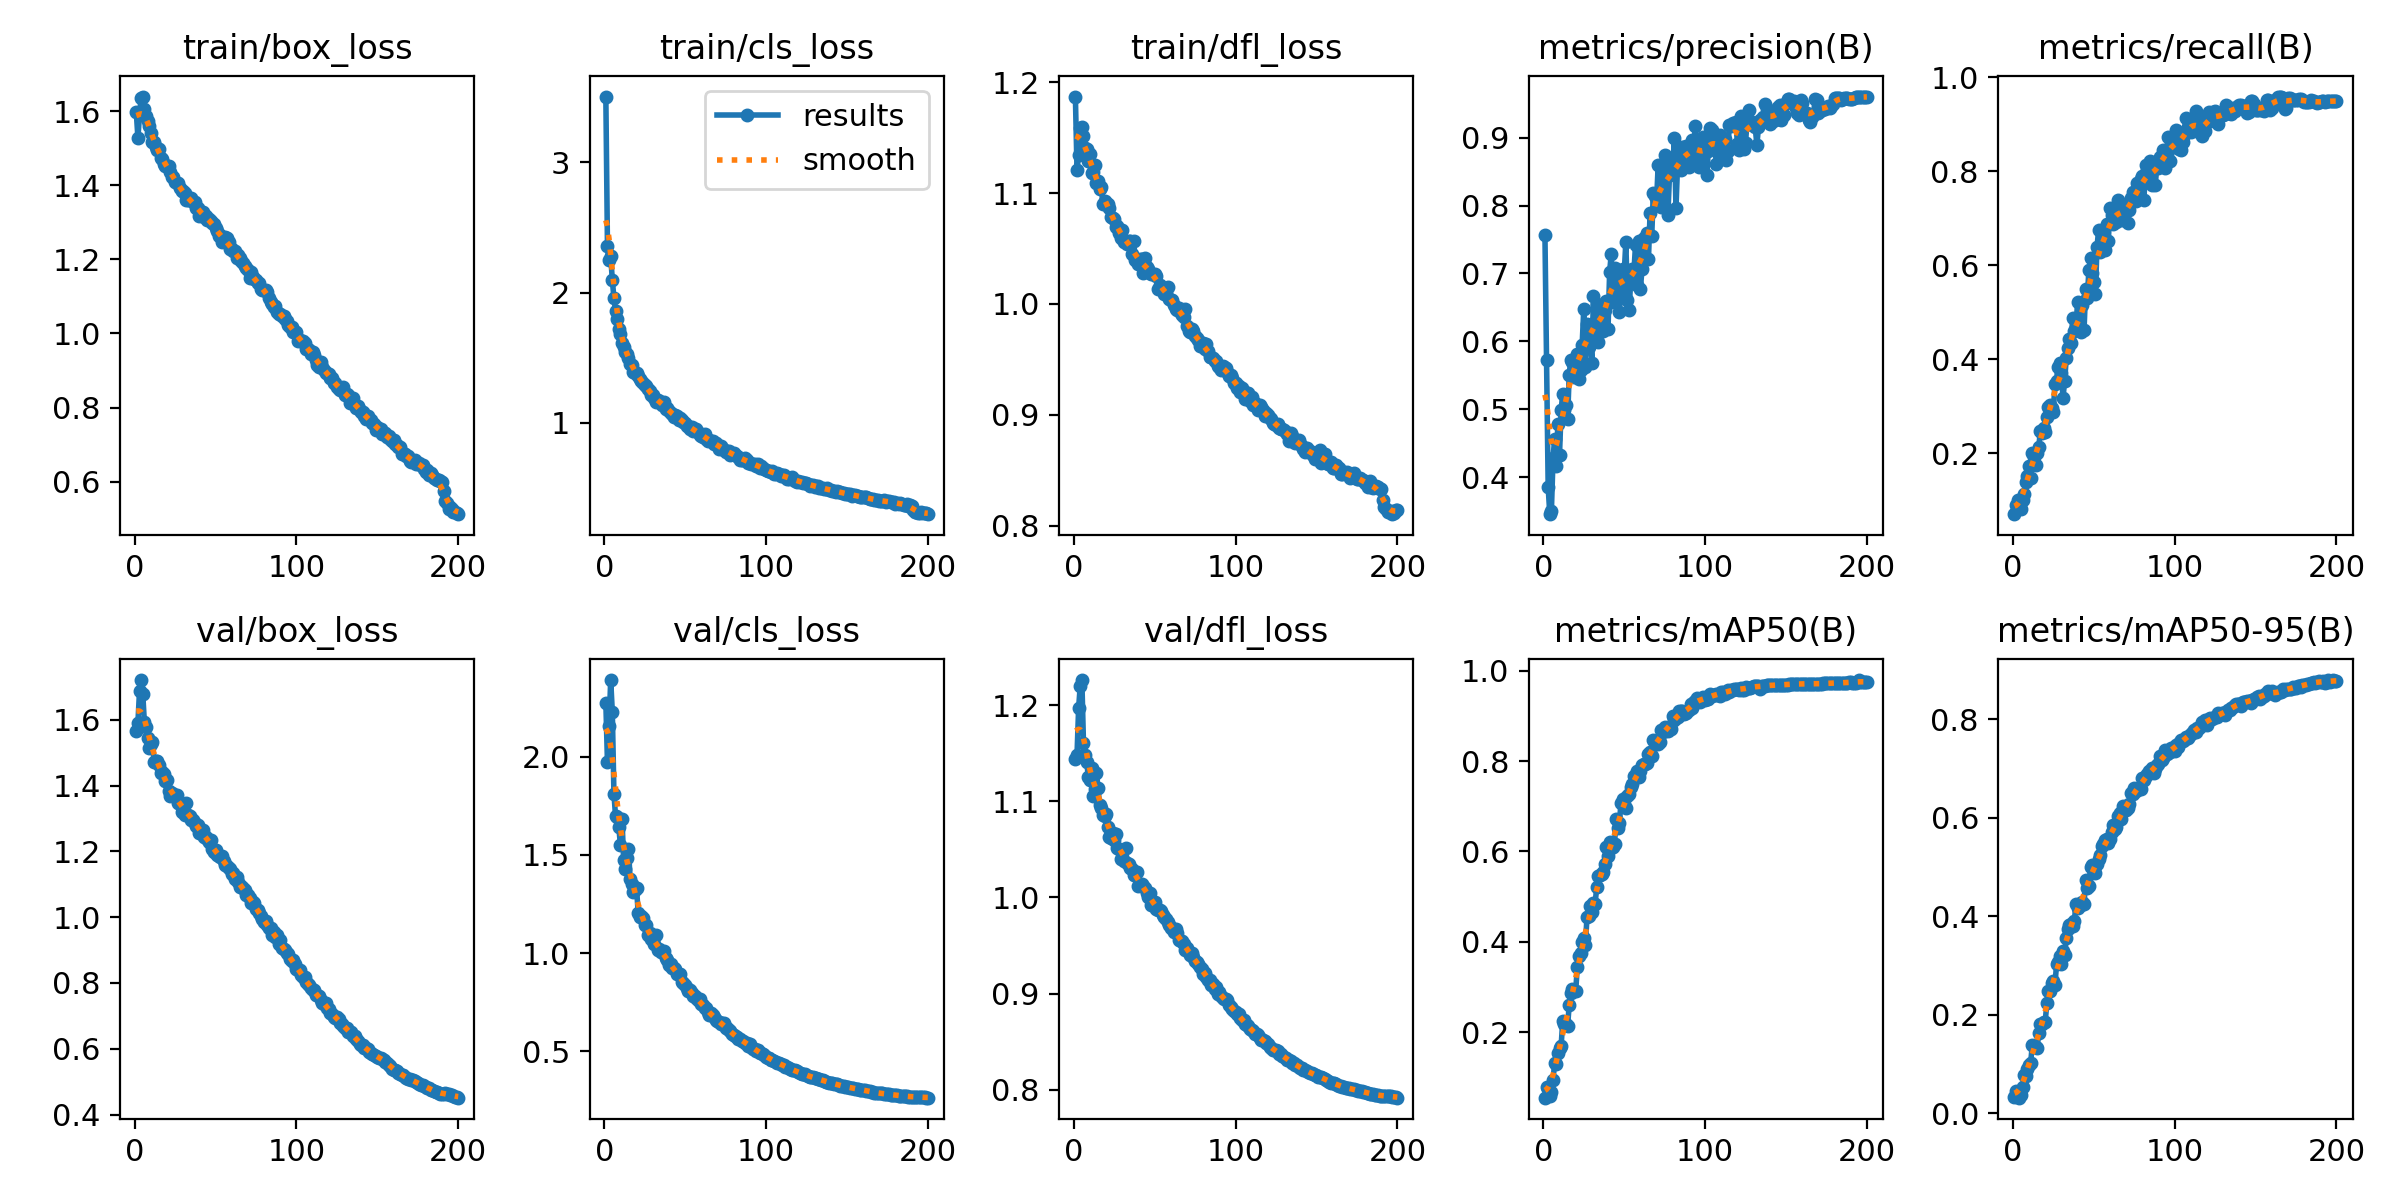

In [ ]:
from IPython.display import Image, display

# Display the results.png
file_path = os.path.join(save_dir, "results.png")
if os.path.exists(file_path):
    display(Image(filename=file_path, width=1000))
else:
    print("Image file not found.")

## Analysis of the Results:
From the above plots, we can tell that the loses and the evaluation metrics easily outperform the YOLOv8m baseline model trained on the same dataset for the same number of epochs.
1. The `mAP50` and `mAP50-95` range between 0.8 to 1.0 indicating that the model is doing an excellent job at object detection for the underwater images.
2. For the loss plots, the losses have dipped to around 0.5 to 0.8 while in the baseline, they teetered around 1.0 to 1.2, indicating that the model has done a better job with optimizing for the images than the baseline.

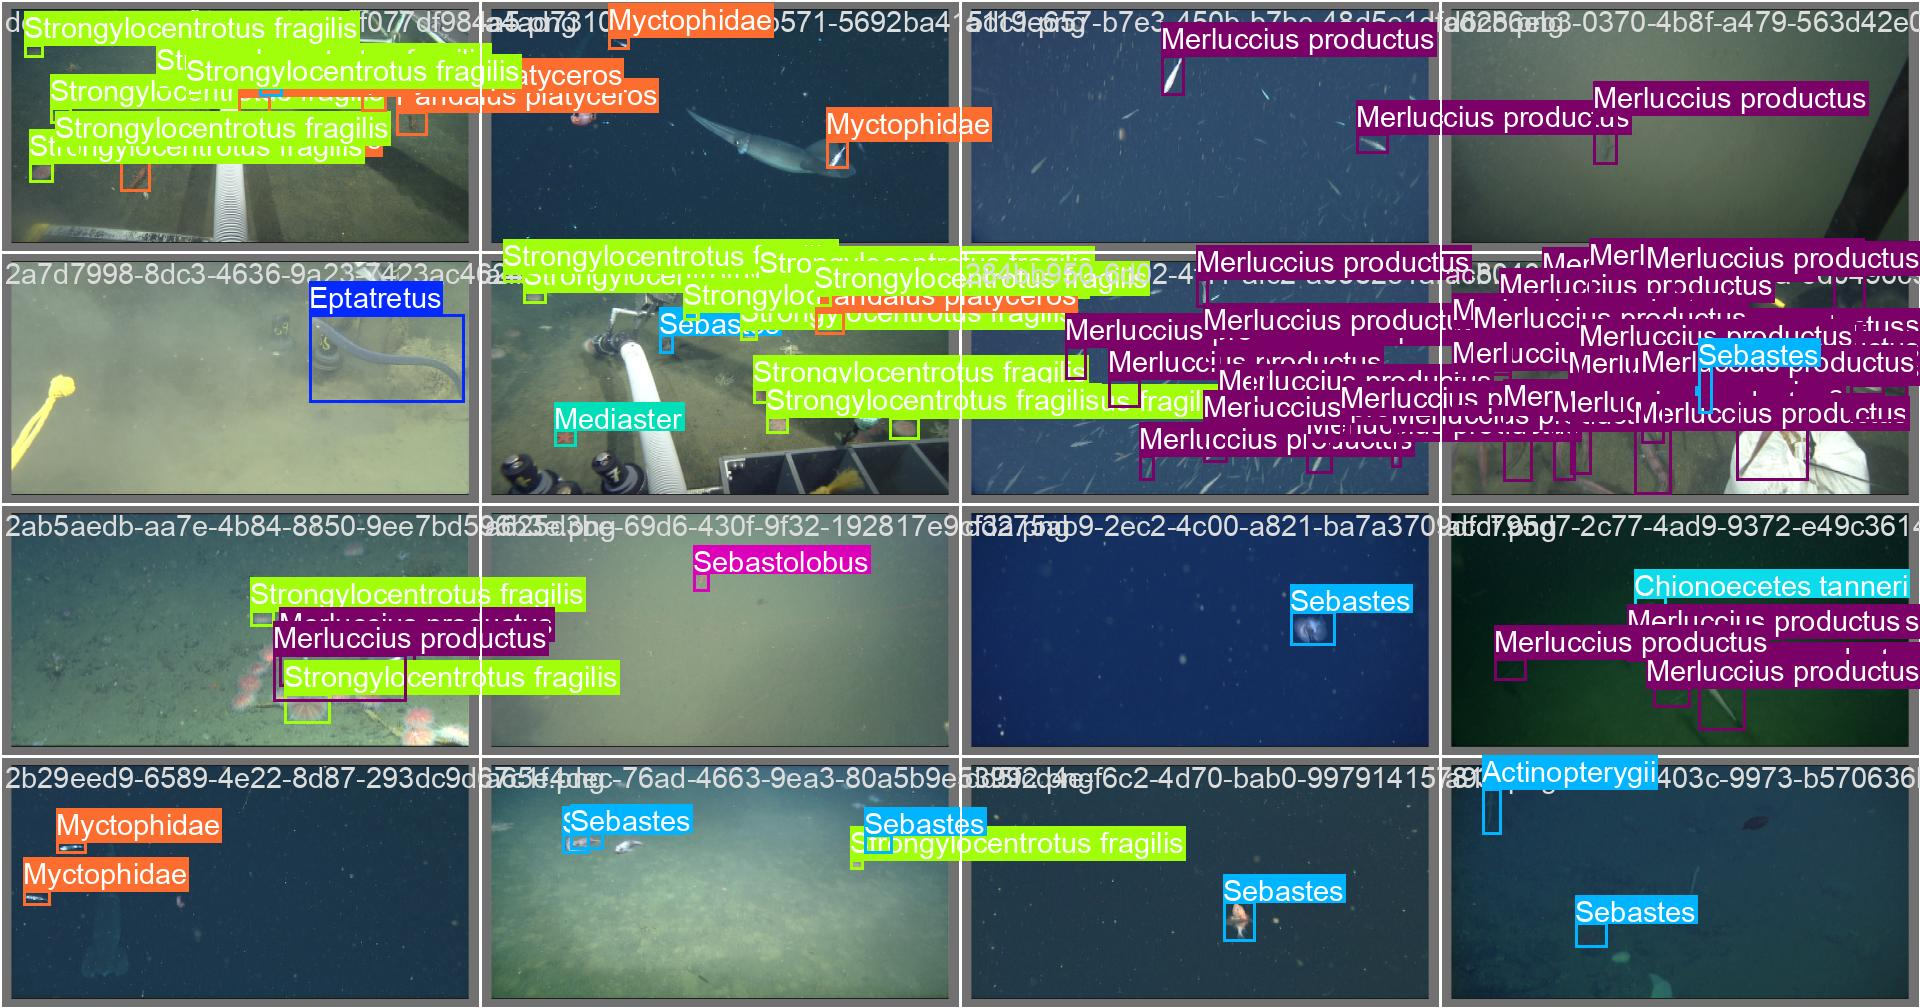

In [ ]:
file_path = os.path.join(save_dir,'val_batch0_labels.jpg')
Image(file_path, height=800, width=1200)